# Exploratory Data Analysis (2/2)
After using the ETL pipeline to load the data into a csv file, we can now use this data to perform some exploratory data analysis. This notebook documents 
* The preprocessing of the data for analysis
* Exploratory Data Analysis on this dataset 
* Visualizations of the data

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; 
import dask.dataframe as dd

The data is loaded by chunks from the csv file into a pandas dataframe as it is a relatively large dataset

In [2]:
%%time
file_path = '../data/cleaned/taxi_data.csv'
chunksize = 10**6

with pd.read_csv(file_path, chunksize=chunksize) as reader:
    taxi_df = pd.concat([chunk for chunk in reader])

taxi_df.head()

CPU times: total: 12.4 s
Wall time: 12.4 s


,booking_id,driver_id,name,date_of_birth,gender,car_model,car_make_year,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,rating,safety_label
0,0,48,Lilia,1974-08-13,Male,Mercedes-Benz,2013-01-01,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,4.0,0
1,0,48,Lilia,1974-08-13,Male,Mercedes-Benz,2013-01-01,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,4.0,0
2,0,48,Lilia,1974-08-13,Male,Mercedes-Benz,2013-01-01,8.0,143.298294,-0.346924,-9.532629,-1.204663,0.014962,-0.050033,0.025118,9.0,0.228454,4.0,0
3,0,48,Lilia,1974-08-13,Male,Mercedes-Benz,2013-01-01,8.0,143.298294,-0.600986,-9.452029,-2.157507,0.004548,-0.011713,-0.004078,11.0,0.228454,4.0,0
4,0,48,Lilia,1974-08-13,Male,Mercedes-Benz,2013-01-01,8.0,143.298294,-0.597546,-9.863403,-1.672711,-0.000401,0.000315,-0.009830,12.0,0.228454,4.0,0


In [3]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7469656 entries, 0 to 7469655
Data columns (total 19 columns):
 #   Column          Dtype  
---  ------          -----  
 0   booking_id      int64  
 1   driver_id       int64  
 2   name            object 
 3   date_of_birth   object 
 4   gender          object 
 5   car_model       object 
 6   car_make_year   object 
 7   accuracy        float64
 8   bearing         float64
 9   acceleration_x  float64
 10  acceleration_y  float64
 11  acceleration_z  float64
 12  gyro_x          float64
 13  gyro_y          float64
 14  gyro_z          float64
 15  second          float64
 16  speed           float64
 17  rating          float64
 18  safety_label    int64  
dtypes: float64(11), int64(3), object(5)
memory usage: 1.1+ GB


# Preprocessing
Initial preprocessing is done to prepare the data for Exploratory Data Analysis. This includes
* Extracting driver's age using their date of birth
* Extracting the car's year of make of make from car_make_year, removing day and month
* Converting seconds to minutes for easier analysis
* Converting speed from m/s to km/h for easier analysis
* Converting compass bearing to their general directions for ease of analysis (North, North-West, East, etc.)
* Dropped driver_id, driver's date_of_birth

Not confirmed
* Calculate magnitude of acceleration
* Calculate magnitude of angular velocity

In [4]:
%%time

cleaned_df = taxi_df.copy()

# set date_of_birth to datetime
cleaned_df['date_of_birth'] = pd.to_datetime(cleaned_df['date_of_birth'])

# extract years from car_make_year
cleaned_df['car_make_year'] = cleaned_df['car_make_year'].apply(lambda x: int(x.split('-')[0]))

# calculate magnitude of acceleration sqrt(x^2 + y^2 + z^2)
a_x = cleaned_df['acceleration_x']
a_y = cleaned_df['acceleration_y']
a_z = cleaned_df['acceleration_z']
cleaned_df['MA (m/s^2)'] = np.sqrt(a_x**2 + a_y**2 + a_z**2)

# magnitude of angular velocity?
g_x = cleaned_df['gyro_x']
g_y = cleaned_df['gyro_y']
g_z = cleaned_df['gyro_z']
cleaned_df['MAV (rad/s)'] = np.sqrt(g_x**2 + g_y**2 + g_z**2)

# convert driver dob to age (current date - dob)
cleaned_df['driver_age'] = pd.to_datetime('today').year - cleaned_df['date_of_birth'].dt.year

# convert seconds to minutes
cleaned_df['duration (mins)'] = round(cleaned_df['second'] / 60, 2)

# convert speed (meters per second) to kilometers per hour
cleaned_df['speed (km/h)'] = cleaned_df['speed'] * 3.6

# convert bearing to categorical variable 
cleaned_df['direction'] = cleaned_df['bearing'].apply(
    lambda x: 
        'North' if x >= 337.5 or x < 22.5 else
        'North East' if x >= 22.5 and x < 67.5 else
        'East' if x >= 67.5 and x < 112.5 else
        'South East' if x >= 112.5 and x < 157.5 else
        'South' if x >= 157.5 and x < 202.5 else
        'South West' if x >= 202.5 and x < 247.5 else
        'West' if x >= 247.5 and x < 292.5 
        else 'North West'
)

# drop unnecessary columns
cols = ['driver_id', 'date_of_birth', 'bearing']
cleaned_df.drop(columns=cols, inplace=True)

# reorder columns
cleaned_df = cleaned_df[['booking_id', 'name', 'driver_age', 'gender', 'car_model', 'car_make_year', 'accuracy', 'direction', 
                         'acceleration_x', 'acceleration_y', 'acceleration_z','MA (m/s^2)', 'gyro_x', 'gyro_y', 'gyro_z', 'MAV (rad/s)', 
                        'second', 'duration (mins)', 'speed (km/h)', 'speed', 'rating', 'safety_label']]

CPU times: total: 11.2 s
Wall time: 11.3 s


In [5]:
cleaned_df.head()

,booking_id,name,driver_age,gender,car_model,car_make_year,accuracy,direction,acceleration_x,acceleration_y,...,gyro_x,gyro_y,gyro_z,MAV (rad/s),second,duration (mins),speed (km/h),speed,rating,safety_label
0,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-1.706207,-9.270792,...,-0.028965,-0.032652,0.015390,0.046282,2.0,0.03,0.822436,0.228454,4.0,0
1,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-1.416705,-9.548032,...,-0.022413,0.005049,-0.025753,0.034511,3.0,0.05,0.822436,0.228454,4.0,0
2,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-0.346924,-9.532629,...,0.014962,-0.050033,0.025118,0.057949,9.0,0.15,0.822436,0.228454,4.0,0
3,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-0.600986,-9.452029,...,0.004548,-0.011713,-0.004078,0.013210,11.0,0.18,0.822436,0.228454,4.0,0
4,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-0.597546,-9.863403,...,-0.000401,0.000315,-0.009830,0.009843,12.0,0.20,0.822436,0.228454,4.0,0


In [6]:
cleaned_df['speed']

0          0.228454
1          0.228454
2          0.228454
3          0.228454
4          0.228454
             ...   
7469651    3.574830
7469652    3.235918
7469653    2.388671
7469654    3.794280
7469655    4.811907
Name: speed, Length: 7469656, dtype: float64

First 5 rows of the dataset after preprocessing

In [7]:
# export cleaned dataset if it doesn't exist
file_path = '../data/cleaned/cleaned_taxi_data.csv'
if not os.path.exists(file_path):
    cleaned_df.to_csv(file_path, index=False)

# Exploratory Data Analysis
After preprocessing, we can now perform some exploratory data analysis on the dataset

In [2]:
%%time
# dask dataframes are "lazy" and data is only loaded when it is needed for a computation
file_path = '../data/cleaned/cleaned_taxi_data.csv'
cleaned_df = dd.read_csv(file_path)
cleaned_df = cleaned_df.persist()  # persist data in memory for faster computation in subsequent cells
cleaned_df.head()

CPU times: total: 31.2 s
Wall time: 7.66 s


,booking_id,name,driver_age,gender,car_model,car_make_year,accuracy,direction,acceleration_x,acceleration_y,...,gyro_x,gyro_y,gyro_z,MAV (rad/s),second,duration (mins),speed (km/h),speed,rating,safety_label
0,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-1.706207,-9.270792,...,-0.028965,-0.032652,0.015390,0.046282,2.0,0.03,0.822436,0.228454,4.0,0
1,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-1.416705,-9.548032,...,-0.022413,0.005049,-0.025753,0.034511,3.0,0.05,0.822436,0.228454,4.0,0
2,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-0.346924,-9.532629,...,0.014962,-0.050033,0.025118,0.057949,9.0,0.15,0.822436,0.228454,4.0,0
3,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-0.600986,-9.452029,...,0.004548,-0.011713,-0.004078,0.013210,11.0,0.18,0.822436,0.228454,4.0,0
4,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-0.597546,-9.863403,...,-0.000401,0.000315,-0.009830,0.009843,12.0,0.20,0.822436,0.228454,4.0,0


## Descriptive Analysis

In [3]:
cleaned_df.dtypes

booking_id           int64
name                object
driver_age           int64
gender              object
car_model           object
car_make_year        int64
accuracy           float64
direction           object
acceleration_x     float64
acceleration_y     float64
acceleration_z     float64
MA (m/s^2)         float64
gyro_x             float64
gyro_y             float64
gyro_z             float64
MAV (rad/s)        float64
second             float64
duration (mins)    float64
speed (km/h)       float64
speed              float64
rating             float64
safety_label         int64
dtype: object

In [4]:
rows, columns = cleaned_df.shape
print(f'Number of rows: {rows.compute()}')  # delayed computation
print(f'Number of columns: {columns}')

Number of rows: 7469656
Number of columns: 22


In [5]:
unique_vals = cleaned_df.nunique().compute().sort_values(ascending=False)
display(unique_vals)

MA (m/s^2)         7121955
MAV (rad/s)        6819953
speed              3139184
speed (km/h)       3138996
gyro_y             2152056
gyro_x             1979270
gyro_z             1683418
acceleration_z     1302936
acceleration_x      904124
acceleration_y      854584
accuracy             38534
booking_id           20000
second                6256
duration (mins)       6256
name                   147
driver_age              24
car_make_year           10
car_model               10
direction                8
rating                   5
gender                   2
safety_label             2
dtype: int64

## Summary Statistics

In [6]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
cleaned_df.describe().compute().T

,count,mean,std,min,25%,50%,75%,max
booking_id,7469656.000,818337115843.641,495334756423.033,0.000,498216206343.000,884763263056.000,1305670058023.000,1709396983975.000
driver_age,7469656.000,39.298,6.690,27.000,35.000,41.000,45.000,50.000
car_make_year,7469656.000,2009.430,2.402,2004.000,2008.000,2011.000,2011.000,2013.000
accuracy,7351631.000,11.621,87.270,0.750,3.900,4.700,8.745,6070.101
acceleration_x,7364539.000,0.069,1.424,-38.984,-0.458,0.097,0.692,66.873
acceleration_y,7346553.000,4.468,8.130,-57.800,6.115,9.194,9.745,72.810
acceleration_z,7370520.000,0.896,3.252,-78.448,-0.685,0.969,3.102,78.056
MA (m/s^2),7148013.000,9.893,1.268,0.005,9.568,9.829,10.151,95.638
gyro_x,7336398.000,-0.002,0.145,-48.456,-0.025,-0.000,0.025,38.708
gyro_y,7329944.000,0.000,0.337,-57.345,-0.028,0.001,0.034,80.315


## Missingness Analysis

In [7]:
null_count = cleaned_df.isna().sum()
null_percent = null_count / rows

nullity = pd.DataFrame({
    'null_count' :  null_count.compute(),
    'null_percent' : null_percent.compute().apply(lambda x: x.compute())
}, index=null_count.index).sort_values(
    by=['null_count', 'null_percent'], ascending=False)

nullity[nullity['null_count'] > 0]

,null_count,null_percent
MAV (rad/s),333036,0.045
MA (m/s^2),321643,0.043
gyro_y,139712,0.019
gyro_x,133258,0.018
speed (km/h),123577,0.017
speed,123577,0.017
acceleration_y,123103,0.016
accuracy,118025,0.016
acceleration_x,105117,0.014
acceleration_z,99136,0.013


In [8]:
num_null_rows = cleaned_df.isna().any(axis=1).sum()
pct_null_rows = num_null_rows / rows

print(f'No. of rows with at least one missing value: {num_null_rows.compute()}')
print(f'Percentage of rows with at least one missing value: {round((pct_null_rows).compute() * 100, 2)}%')

No. of rows with at least one missing value: 853937
Percentage of rows with at least one missing value: 11.43%


---

## Analysis Setup

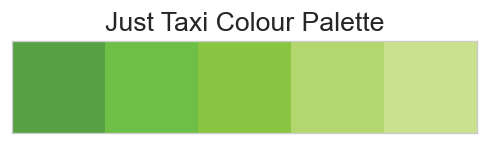

In [9]:
# set style
sns.set_style('whitegrid')
# set dpi to 120 for better resolution
plt.rcParams['figure.dpi'] = 120

# set font family
hfont = {'fontname':'Arial'}
# set colour palette for better visualisations
palette = ['#58A044', '#6DBF46', '#89C541', '#B3D66F', '#CAE18E']

sns.palplot(palette)
plt.title('Just Taxi Colour Palette', fontsize=16)
plt.grid(False)
plt.show()

---

## Univariate Analysis

### Categorical Variables

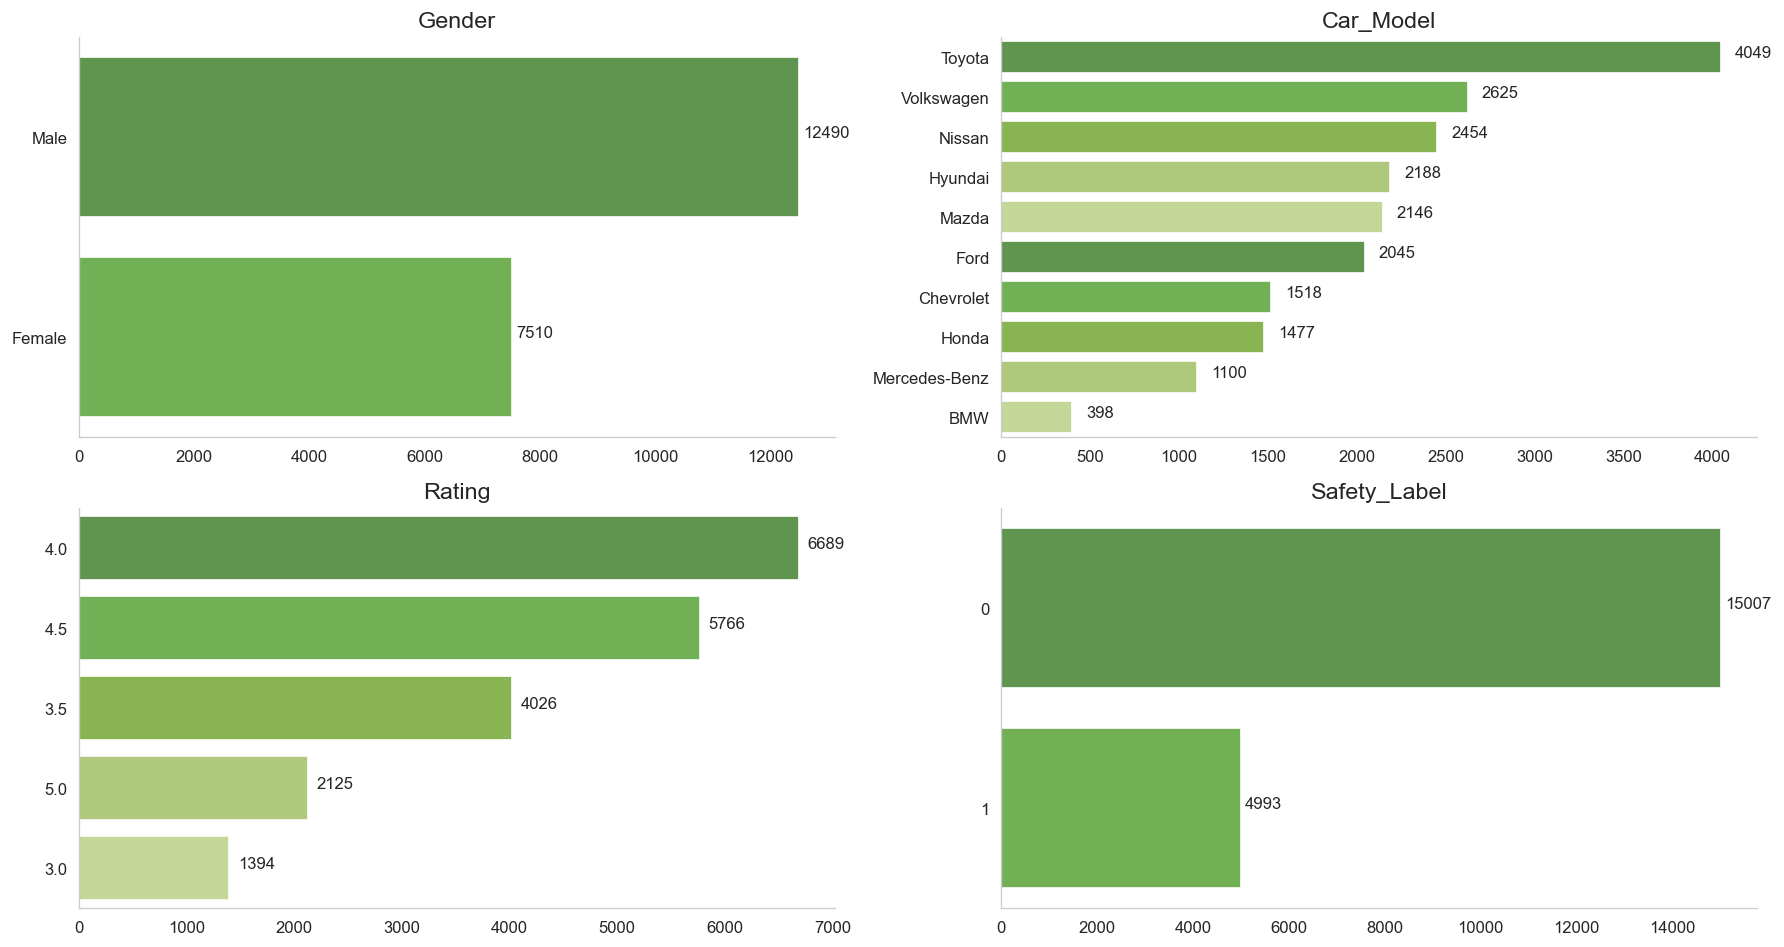

In [10]:
univariate_df = cleaned_df.groupby('booking_id').first().compute()
cat_cols = ['gender', 'car_model', 'rating', 'safety_label']

# plot countplots of each categorical vairable from dask dataframe
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(y=col, data=univariate_df, ax=axes[i], palette=palette, order=univariate_df[col].value_counts().index)
    axes[i].set_title(f'{col.title()}', fontsize=14, **hfont)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

    # remove scientific notation on x-axis
    axes[i].get_xaxis().get_major_formatter().set_scientific(False)

    # label bars with counts
    for p in axes[i].patches:
        axes[i].annotate(f'{p.get_width():.0f}', (p.get_width() + 80, p.get_y() + 0.4), fontsize=10, **hfont)

    # remove spines and gridlines
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    axes[i].grid(False)

plt.tight_layout()
plt.show()

### Numerical Variables

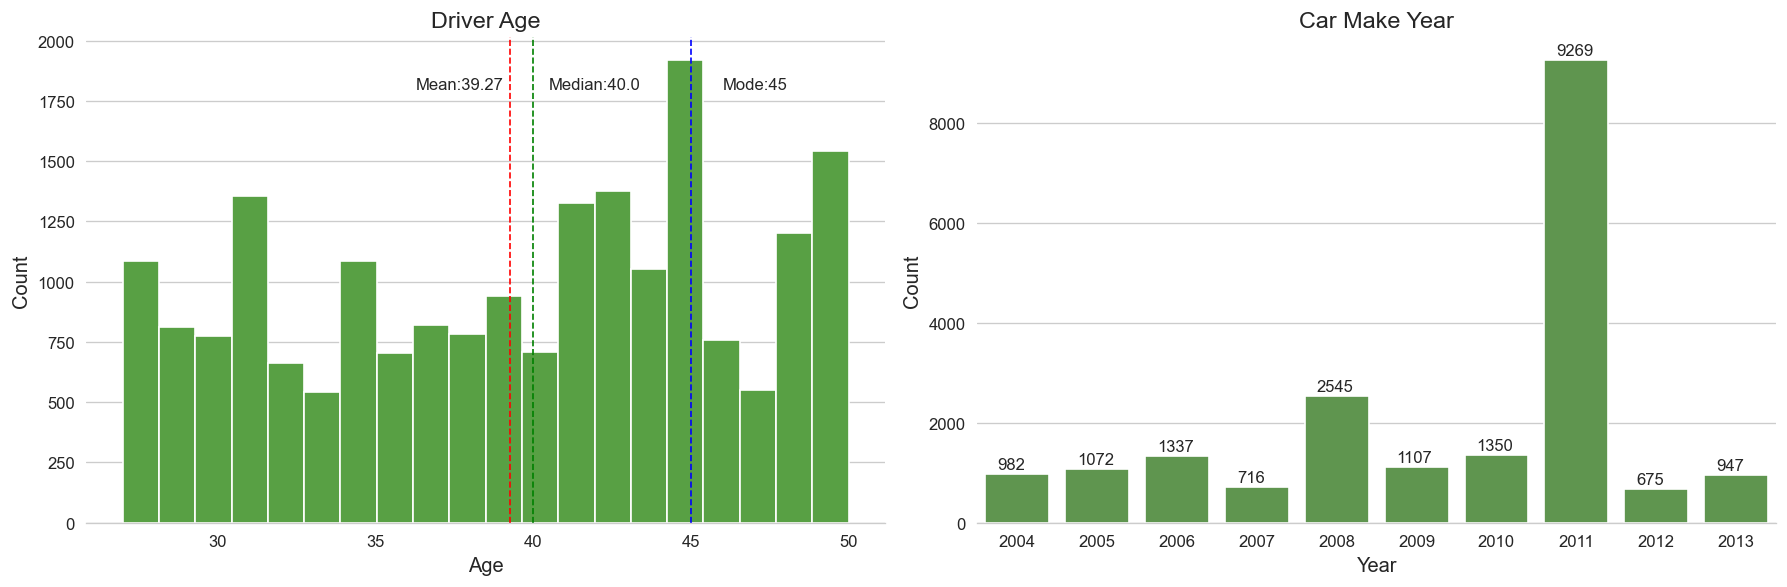

In [11]:
numerical_cols = ['driver_age', 'car_make_year']

#sub plot histograms of driver age and count of car make year
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(univariate_df['driver_age'], bins=20, color=palette[0])
axes[0].set_title('Driver Age', fontsize=14, **hfont)
axes[0].set_xlabel('Age', fontsize=12, **hfont)
axes[0].set_ylabel('Count', fontsize=12, **hfont)

# highlight mean, median and mode
axes[0].axvline(univariate_df['driver_age'].mean(), color='red', linestyle='dashed', linewidth=1)
axes[0].axvline(univariate_df['driver_age'].median(), color='green', linestyle='dashed', linewidth=1)
axes[0].axvline(univariate_df['driver_age'].mode()[0], color='blue', linestyle='dashed', linewidth=1)

# annotate mean, median and mode
axes[0].annotate(f'Mean:{round(univariate_df["driver_age"].mean(), 2)}', (univariate_df["driver_age"].mean() - 3, 1800), fontsize=10, **hfont)
axes[0].annotate(f'Median:{round(univariate_df["driver_age"].median(), 2)}', (univariate_df["driver_age"].median() + 0.5, 1800), fontsize=10, **hfont)
axes[0].annotate(f'Mode:{round(univariate_df["driver_age"].mode()[0], 2)}', (univariate_df["driver_age"].mode()[0] + 1, 1800), fontsize=10, **hfont)

# despine
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].grid(axis='x')

sns.countplot(x='car_make_year', data=univariate_df, color=palette[0], ax=axes[1])
axes[1].set_title('Car Make Year', fontsize=14, **hfont)
axes[1].set_xlabel('Year', fontsize=12, **hfont)
axes[1].set_ylabel('Count', fontsize=12, **hfont)

# despine
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['left'].set_visible(False)

# label bars with counts with padding
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():.0f}', (p.get_x() + 0.15, p.get_height() + 100), fontsize=10, **hfont)


plt.tight_layout()
plt.show()

---

## Outlier Analysis


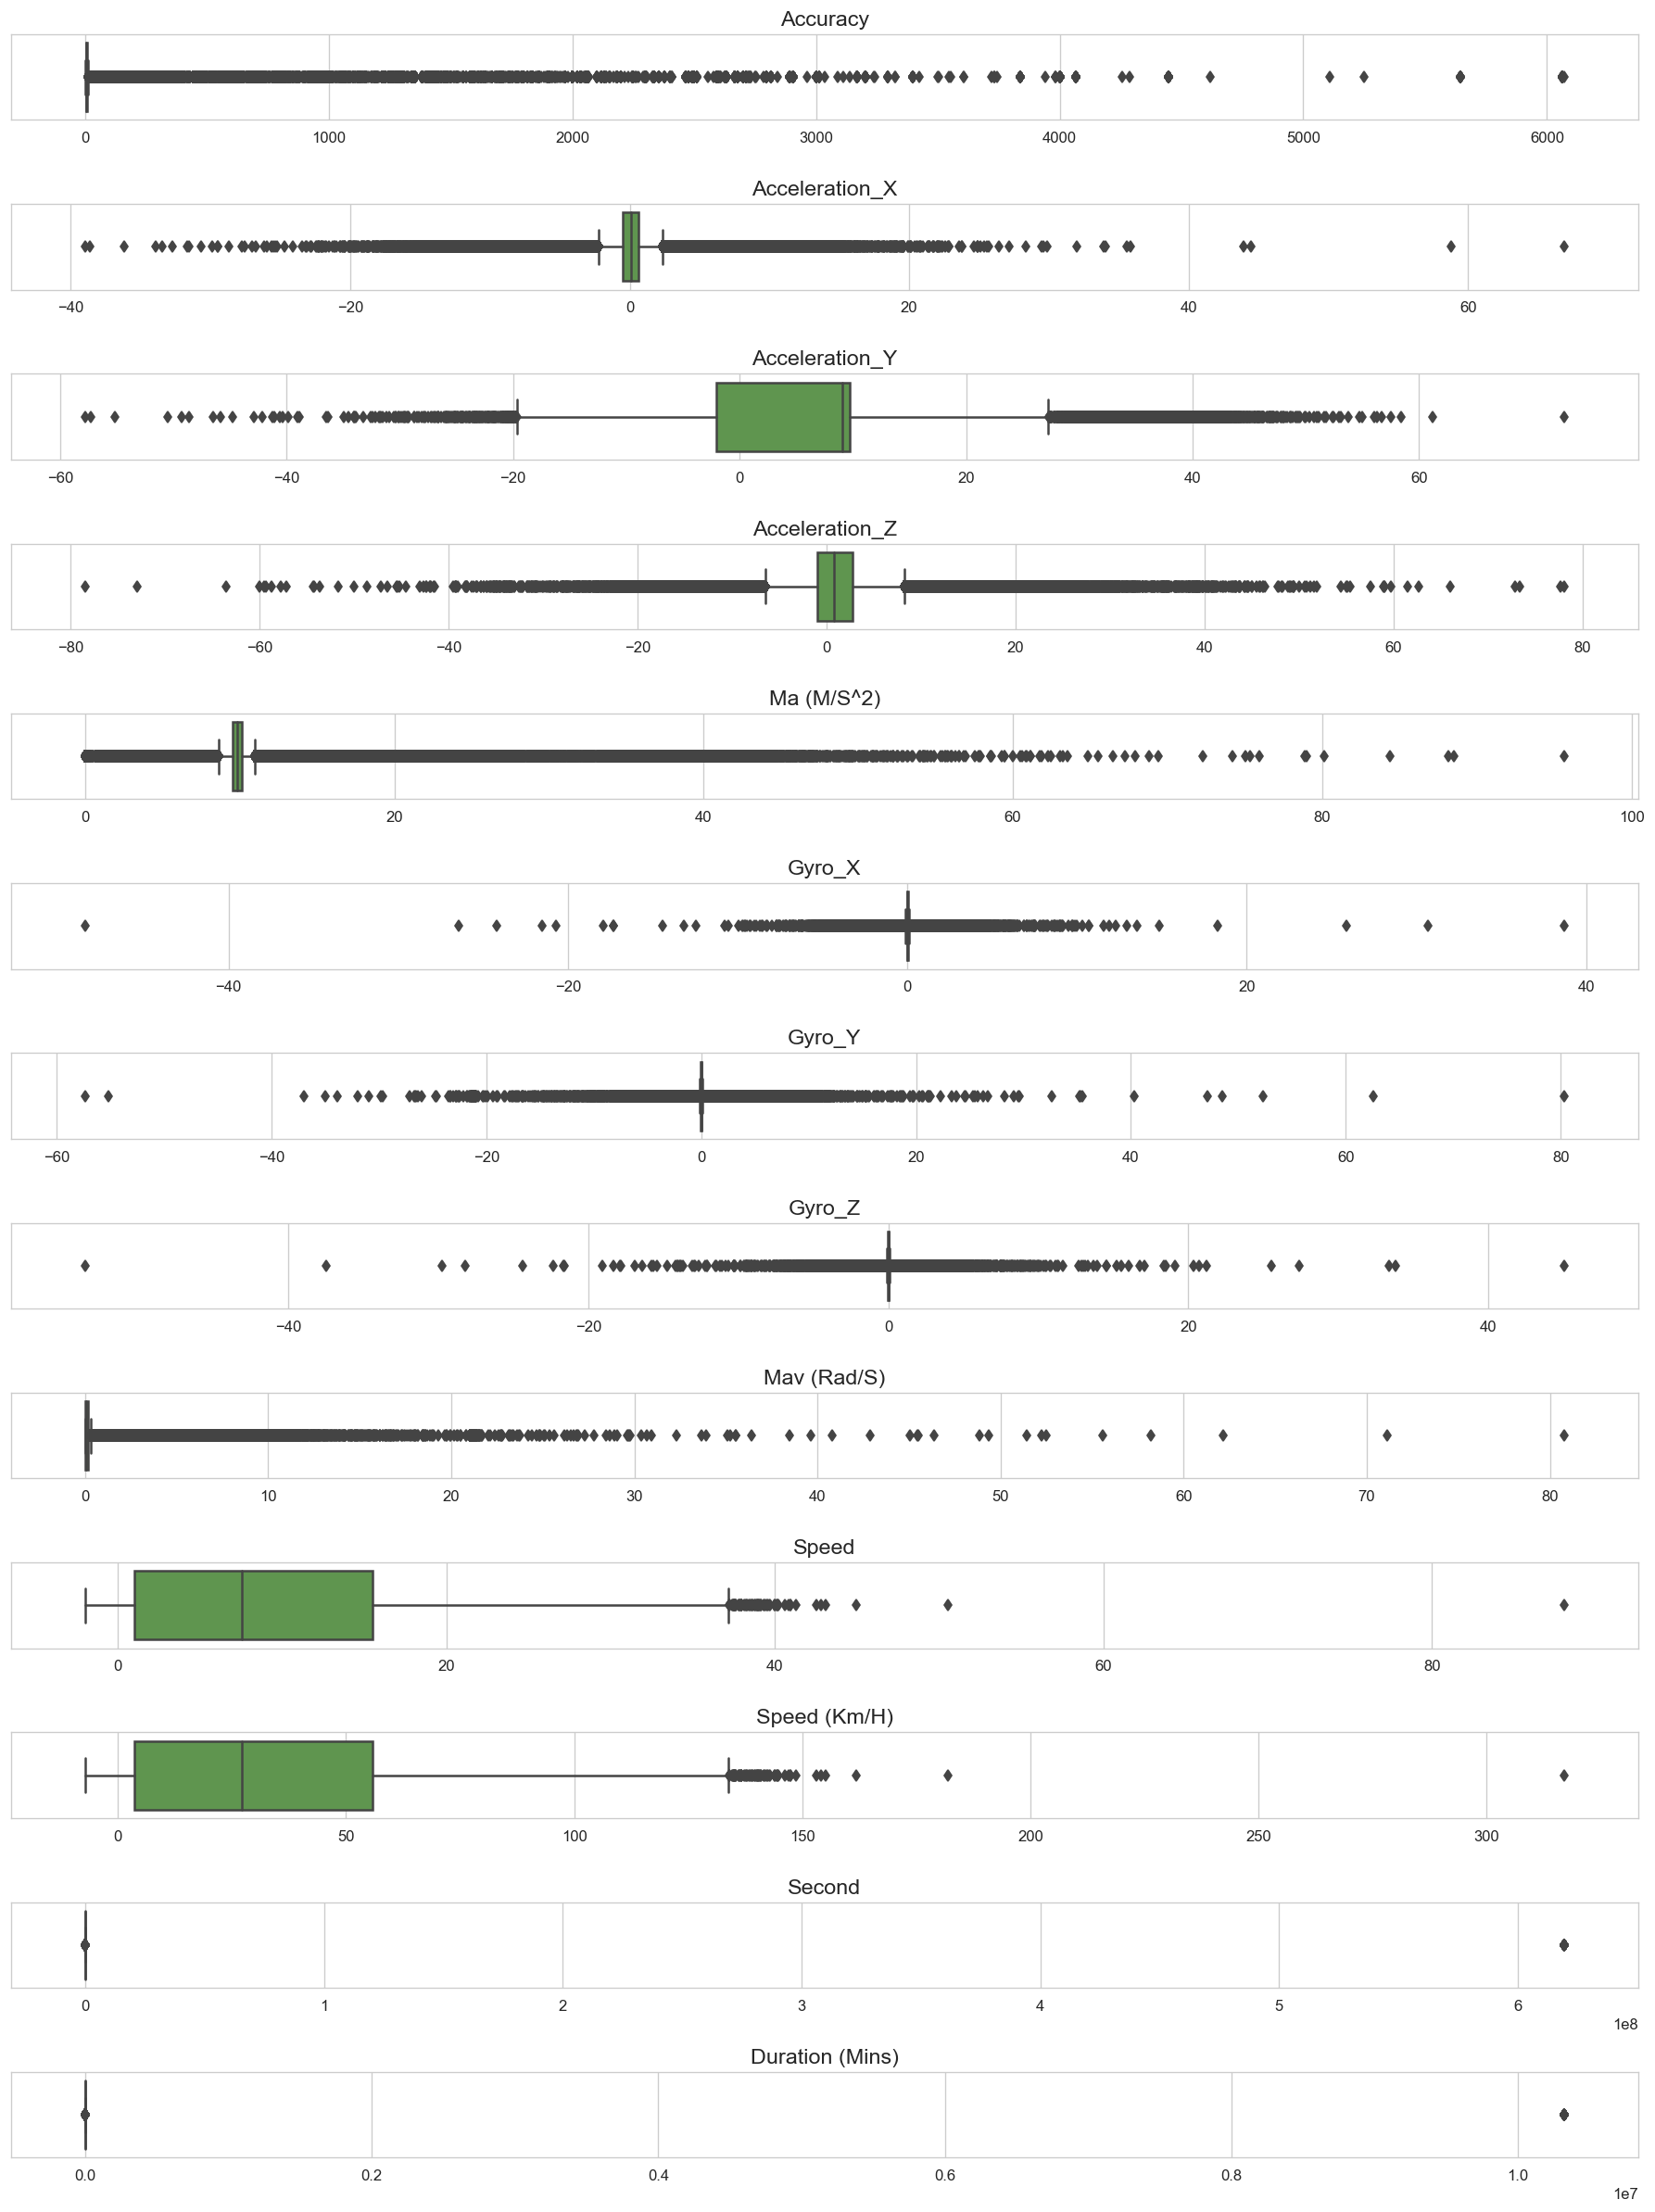

In [32]:
continuous_cols = ['accuracy', 'acceleration_x', 'acceleration_y', 'acceleration_z', 'MA (m/s^2)', 'gyro_x', 'gyro_y', 'gyro_z', 'MAV (rad/s)', 'speed', 'speed (km/h)', 'second', 'duration (mins)'] 

#plot boxplots of each continuous variable
fig, axes = plt.subplots(len(continuous_cols), 1, figsize=(15, 20))
axes = axes.flatten()

for i, col in enumerate(continuous_cols):
    sns.boxplot(x=col, data=cleaned_df.compute(), ax=axes[i], palette=palette)
    axes[i].set_title(f'{col.title()}', fontsize=14, **hfont)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

---

dont remove yet

In [13]:
# age_df = cleaned_df.groupby('name')['driver_age'].mean().reset_index()
# age_df['driver_age'] = age_df['driver_age'].astype(int)

# fig, axes = plt.subplots(1, 2 ,figsize=(12, 6))

# # plot distribution of driver age
# sns.histplot(data=age_df, x='driver_age', bins='auto', color=palette[0], alpha=1, ax=axes[0])
# axes[0].set_xlabel('Age', fontsize=12, **hfont)
# axes[0].set_ylabel('Count', fontsize=12, **hfont)
# axes[0].grid(axis='x')
# axes[0].spines['top'].set_visible(False)
# axes[0].spines['right'].set_visible(False)
# axes[0].spines['left'].set_visible(False)
# axes[0].spines['bottom'].set_color('k')

# # boxplot of drivers age by gender
# sns.boxplot(y=age_df['driver_age'], color=palette[0], width=.2, ax=axes[1])
# axes[1].set_ylabel('Age', fontsize=12, **hfont)
# axes[1].spines[:].set_color('k')

# fig.suptitle('Driver Age Distribution', fontweight='semibold', fontsize=16, **hfont)
# plt.tight_layout()
# plt.show()

In [14]:
# gender_df = cleaned_df.groupby('name')['gender'].value_counts().to_frame('count').reset_index()
# counts = gender_df['gender'].value_counts()

# fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# # barchart of gender
# ax = sns.barplot(x=counts.index, y=counts.values, palette=palette, ax=axes[0])
# ax.bar_label(ax.containers[0], fontsize=12, **hfont)
# axes[0].set_title('Gender count', fontsize=16, fontweight='semibold', **hfont)
# axes[0].set_xlabel('Gender', fontsize=12, **hfont)
# axes[0].set_ylabel('Count', fontsize=12, **hfont)
# axes[0].get_yaxis().get_major_formatter().set_scientific(False)
# axes[0].spines['top'].set_visible(False)
# axes[0].spines['right'].set_visible(False)
# axes[0].spines['left'].set_visible(False)
# axes[0].spines['bottom'].set_color('k')

# # donut chart
# axes[1].pie(counts, colors=palette, labels=counts.index, autopct='%.0f%%', pctdistance=.8, labeldistance=1.1,
#           startangle=90, radius=1, wedgeprops=dict(width=.4, edgecolor='white'))
# axes[1].set_title('Proportion of genders', fontsize=16, fontweight='semibold', **hfont)
# axes[1].axis('equal')
# plt.show()

In [15]:
# model_df = cleaned_df.groupby('name')['car_model'].value_counts().to_frame('count').reset_index()
# counts = model_df['car_model'].value_counts()

# colors = [palette[-1] for _ in range(10)]
# colors[0] = colors[1] = colors[2] = palette[0]

# plt.figure(figsize=(12, 6))
# ax = sns.barplot(x=counts.values, y=counts.index, palette=colors)
# ax.bar_label(ax.containers[0], fontsize=12, padding=5, **hfont)
# plt.title('Count of car models', fontsize=16, fontweight='semibold', **hfont)
# plt.xticks([])
# plt.xlabel('')
# plt.ylabel('')
# sns.despine(left=True, bottom=True)

# plt.show()

In [16]:
# colors = [palette[-1] for _ in range(10)]
# colors[2] = colors[4] = colors[6] = colors[7] = palette[0]

# years_df = cleaned_df.groupby('name')['car_make_year'].value_counts().to_frame('count').reset_index()
# counts = years_df['car_make_year'].value_counts()

# plt.figure(figsize=(12, 6))
# ax = sns.barplot(x=counts.index, y=counts.values, palette=colors)
# ax.bar_label(ax.containers[0], fontsize=12, padding=5, **hfont)
# plt.title('Count of car make year', fontsize=16, fontweight='semibold', **hfont)
# plt.xticks([])
# plt.xlabel('')
# plt.ylabel('')
# sns.despine(left=True, bottom=True)

# plt.show()

In [17]:
# # plot a histogram of accuracy
# plt.figure(figsize=(10, 5))
# plt.hist(x=cleaned_df['accuracy'], bins=7, range=(0, 70), color=palette[0], edgecolor='white')
# plt.title('Accuracy distribution', fontsize=16, fontweight='semibold', **hfont)
# plt.xlabel('Accuracy', fontsize=14, **hfont)
# plt.ylabel('Count', fontsize=14, **hfont)

# # annotate histogram
# # for p in plt.gca().patches:
# #     plt.gca().annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
# #                        ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

# # remove scientific notation on y-axis
# plt.gca().get_yaxis().get_major_formatter().set_scientific(False)

# # remove top, left and right spines
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)

# # set color of bottom spine
# plt.gca().spines['bottom'].set_color('k')

# plt.grid(axis='x')
# plt.show()

In [18]:
# # count plot of direction in order
# plt.figure(figsize=(10, 5))
# ax = sns.countplot(x=cleaned_df['direction'], order=cleaned_df['direction'].value_counts().index,
#                 color=palette[0], edgecolor='white')

# plt.title('Count of direction', fontsize=16, fontweight='semibold', **hfont)
# plt.xticks()
# plt.xlabel('')
# plt.ylabel('')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_color('k')
# ax.spines['bottom'].set_visible(False)

# # annotate countplot
# for p in ax.patches:
#     ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
#                 ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

# # remove scientific notation on y-axis
# plt.gca().get_yaxis().get_major_formatter().set_scientific(False)

# plt.show()

In [19]:
# # plot a histogram of acceleration_x, acceleration_y and acceleration_z
# plt.figure(figsize=(10, 5))
# plt.hist(x=cleaned_df['acceleration_x'], bins=50, range=(-80, 80), color=palette[0], edgecolor='white', alpha=0.7, label='acceleration_x')
# plt.hist(x=cleaned_df['acceleration_y'], bins=50, range=(-80, 80), color=palette[2], edgecolor='white', alpha=0.7, label='accleleration_y')
# plt.hist(x=cleaned_df['acceleration_z'], bins=50, range=(-80, 80), color=palette[1], edgecolor='white', alpha=0.7, label='acceleration_z')
# plt.title('Acceleration distribution', fontsize=16, fontweight='semibold', **hfont)
# plt.xlabel('Acceleration', fontsize=14, **hfont)
# plt.ylabel('Count', fontsize=14, **hfont)

# # remove scientific notation on y-axis
# plt.gca().get_yaxis().get_major_formatter().set_scientific(False)

# # remove top, left and right spines
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)

# # set color of bottom spine
# plt.gca().spines['bottom'].set_color('k')

# plt.grid(axis='x')
# plt.show()

In [20]:
# # plot a histogram of magnitude of acceleration
# plt.figure(figsize=(10, 5))
# plt.hist(x=cleaned_df['MA (m/s^2)'], bins=100, range=(0, 100), color=palette[0], edgecolor='white')
# plt.title('Magnitude of acceleration distribution', fontsize=16, fontweight='semibold', **hfont)
# plt.xlabel('Magnitude of acceleration', fontsize=14, **hfont)
# plt.ylabel('Count', fontsize=14, **hfont)

# # remove scientific notation on y-axis
# plt.gca().get_yaxis().get_major_formatter().set_scientific(False)

# # remove top, left and right spines
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)

# # set color of bottom spine
# plt.gca().spines['bottom'].set_color('k')

# plt.grid(axis='x')
# plt.show()

In [21]:
# # plot a histogram of gyro_x, gyro_y and gyro_z
# plt.figure(figsize=(10, 5))

# plt.hist(x=cleaned_df['gyro_x'], bins=20, range=(-60, 40), color=palette[0], edgecolor='white', alpha=0.7, label='gyro_x')
# plt.hist(x=cleaned_df['gyro_y'], bins=20, range=(-60, 90), color=palette[2], edgecolor='white', alpha=0.7, label='gyro_y')
# plt.hist(x=cleaned_df['gyro_z'], bins=20, range=(-60, 50), color=palette[1], edgecolor='white', alpha=0.7, label='gyro_z')

# plt.title('Gyro distribution', fontsize=16, fontweight='semibold', **hfont)
# plt.xlabel('Gyro', fontsize=14, **hfont)
# plt.ylabel('Count', fontsize=14, **hfont)

# # remove scientific notation on y-axis
# plt.gca().get_yaxis().get_major_formatter().set_scientific(False)

# # remove top, left and right spines
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)

# # set color of bottom spine
# plt.gca().spines['bottom'].set_color('k')

# plt.legend()
# plt.grid(axis='x')
# plt.show()

In [22]:
# # gyro x y z boxplots
# plt.figure(figsize=(10, 5))
# sns.boxplot(data=cleaned_df[['gyro_x', 'gyro_y', 'gyro_z']], palette=palette)
# plt.title('Gyro distribution', fontsize=16, fontweight='semibold', **hfont)
# plt.xlabel('Gyro', fontsize=14, **hfont)
# plt.ylabel('Count', fontsize=14, **hfont)

In [23]:
# # accel x y z boxplots
# plt.figure(figsize=(10, 5))
# sns.boxplot(data=cleaned_df[['acceleration_x', 'acceleration_y', 'acceleration_z']], palette=palette)
# plt.title('Acceleration distribution', fontsize=16, fontweight='semibold', **hfont)
# plt.xlabel('Acceleration', fontsize=14, **hfont)
# plt.ylabel('Count', fontsize=14, **hfont)

In [24]:
# magnitude of angular velocity distribution - WIP

In [25]:
# max_trip_seconds = cleaned_df.groupby('booking_id')['second'].max()
# max_trip_minutes = max_trip_seconds / 60

# fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# axes[0].hist(x=max_trip_seconds, bins=20, range=(0, 4000), color=palette[0], edgecolor='white')
# axes[0].set_xlabel('Trip duration (seconds)', fontsize=14, **hfont)
# axes[0].set_ylabel('Count', fontsize=14, **hfont)
# axes[0].spines['top'].set_visible(False)
# axes[0].spines['right'].set_visible(False)
# axes[0].spines['left'].set_visible(False)
# axes[0].spines['bottom'].set_color('k')
# axes[0].grid(axis='x')

# axes[1].hist(x=max_trip_minutes, bins=20, range=(0, 100), color=palette[0], edgecolor='white')
# axes[1].set_xlabel('Trip duration (minutes)', fontsize=14, **hfont)
# axes[1].spines['top'].set_visible(False)
# axes[1].spines['right'].set_visible(False)
# axes[1].spines['left'].set_visible(False)
# axes[1].spines['bottom'].set_color('k')
# axes[1].grid(axis='x')

# fig.suptitle('Trip duration distribution', fontsize=20, fontweight='semibold', **hfont)

# plt.show()

In [26]:
# # plot a histogram of speed
# plt.figure(figsize=(10, 5))

# plt.hist(x=cleaned_df['speed (km/h)'], bins=100, range=(0, 320), color=palette[0], edgecolor='white')
# plt.title('Speed distribution', fontsize=16, fontweight='semibold', **hfont)
# plt.xlabel('Speed (km/h)', fontsize=14, **hfont)
# plt.ylabel('Count', fontsize=14, **hfont)

# # remove scientific notation on y-axis
# plt.gca().get_yaxis().get_major_formatter().set_scientific(False)

# # remove top, left and right spines
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)

# # set color of bottom spine
# plt.gca().spines['bottom'].set_color('k')

# plt.grid(axis='x')
# plt.show()

In [27]:
# # rating, boxplots, histograms

# # plot subplots of rating with boxplots, histograms, and donut charts
# fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# # histogram
# axes[0].hist(cleaned_df['rating'], color=palette[0])
# axes[0].set_xlabel('Rating', fontsize=14, **hfont)
# axes[0].set_ylabel('Count', fontsize=14, **hfont)
# axes[0].spines['top'].set_visible(False)
# axes[0].spines['right'].set_visible(False)
# axes[0].spines['left'].set_visible(False)
# axes[0].spines['bottom'].set_color('k')
# axes[0].grid(axis='x')

# # remove scientific notation on y-axis
# axes[0].get_yaxis().get_major_formatter().set_scientific(False)

# # boxplot
# sns.boxplot(y=cleaned_df['rating'], width=.2, ax=axes[1], palette=palette)
# axes[1].set_ylabel('Rating', fontsize=14, **hfont)
# axes[1].spines[:].set_color('k')


# # donut chart
# rating_counts = cleaned_df['rating'].value_counts()
# rating_counts = rating_counts.sort_index()
# rating_counts = rating_counts.reset_index()
# rating_counts.columns = ['rating', 'count']
# rating_counts['percent'] = rating_counts['count'] / rating_counts['count'].sum() * 100

# # create a circle for the center of the plot
# my_circle = plt.Circle((0, 0), 0.4, color='white')

# # create donut chart
# plt.pie(rating_counts['count'], colors=palette, labels=rating_counts['rating'], autopct='%.0f%%', pctdistance=1.15, labeldistance=1.3,
#           startangle=90, radius=1, wedgeprops=dict(width=.4, edgecolor='white'))
# p = plt.gcf()
# p.gca().add_artist(my_circle)

# fig.suptitle('Rating Distribution and Proportions', fontsize=16, fontweight='semibold', **hfont)
# plt.show()

In [28]:
# # donut chart of safety labels
# safety_labels = cleaned_df['safety_label'].value_counts()
# safety_labels = safety_labels.sort_index()
# safety_labels = safety_labels.reset_index()
# safety_labels.columns = ['safety_label', 'count']
# safety_labels['percent'] = safety_labels['count'] / safety_labels['count'].sum() * 100

# # create a circle for the center of the plot
# my_circle = plt.Circle((0, 0), 0.4, color='white')

# # create donut chart
# plt.pie(safety_labels['count'], colors=palette, labels=['Safe', 'Dangerous'], autopct='%.0f%%', pctdistance=.8, labeldistance=1.1,
#             startangle=90, radius=1, wedgeprops=dict(width=.4, edgecolor='white'))

# p = plt.gcf()
# p.gca().add_artist(my_circle)

# plt.title('Safety Label Proportions', fontsize=16, fontweight='semibold', **hfont)
# plt.show()